# Processing thread for XMM-Newton EPIC observations

## Step 03, tailored for PN Large Window mode

The following is happening here:

1. Sets the folders where the ODF is and where the products will be saved
2. Checks if the necessary SAS files are available: ccf.cif and sets some environmental variables
3. Generates a rate curve 
4. Generates the good time intervals based on a criterium: median + 3*mad
5. Filter the event list with the GTI
6. Plot the result with the GTI
7. Generates an image in user provided energy band
8. Displays the image


In [86]:
import os
import subprocess
import sys
import logging
import glob

import numpy as np

from astropy.io import fits
from astropy.stats import mad_std
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy import units as u

import scipy.ndimage as ndimage

import matplotlib.pylab as plt
%matplotlib inline

In [87]:
# function to run shell process
# get the SAS version, will be used for the output folder 
def run_command(command):
    try:
        result = subprocess.run([command], shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode = result.returncode
        if retcode < 0:
            print("Warning: \"{}\" was terminated by signal {} \n {}".format(command,-retcode,result.stdout.decode()))
            logging.warning("\"{}\" was terminated by signal {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            print("Info: \"{}\" returned {} \n {}".format(command,retcode,result.stdout.decode()))
            logging.info("\"{}\" returned {} \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print("Execution of \"{}\" failed:".format(command), e, file=sys.stderr)
        logging.error("Execution of \"{}\" failed:".format(command), e, file=sys.stderr)
    return retcode

In [88]:
#obsid = "0721010401"
obsid = "0721010501"

home = os.path.expanduser('~')
wdir = f"{home}/IVAN/Cu-line"

if (not os.path.isdir(wdir)):
    print (f"The input working folder {wdir} does not exist.")
    raise FileNotFoundError
#
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename=f'{wdir}/{obsid}_proc_step03.log',
                    filemode='w')
# the ODF directory
odfDir = os.path.join(wdir,obsid)
if (not os.path.isdir(odfDir)):
    print (f"The ODF folder {odfDir} does not exist! Cannot continue!")
    logging.error (f"The ODF folder {odfDir} does not exist! Cannot continue!")
    raise FileNotFoundError
#
ppsDir = os.path.join(odfDir,"PN_LW")
#
if (not os.path.isdir(ppsDir)):
    print (f"PPS folder {ppsDir} does not exist. You need to run step02 before running step03")
    logging.error (f"PPS folder {ppsDir} does not exist. You need to run step02 before running step03")
    raise FileNotFoundError
#
os.chdir(ppsDir)

In [89]:
os.environ['SAS_CCFPATH'] = '/xdata/ccf/pub'
os.environ["SAS_ODF"] = odfDir
ccffile = os.path.join(odfDir,"ccf.cif")
if (not os.path.isfile(ccffile)):
    print (f"No ccf.cif file found in ODF folder {odfDir}")
    print ("     ===> This means epic_proc_step01 was not run?")
    logging.error(f"No CCF file ccf.cif found in {odfDir}")
    raise FileNotFoundError
#
os.environ["SAS_CCF"] = ccffile
logging.info(f"Set SAS_ODF to {odfDir}")
logging.info(f"Set SAS_CCF to {ccffile}")
#

In [90]:
# find the event lists
haveEvlist = False
evfind = glob.glob(f"{ppsDir}/*PIEVLI*")
if (len(evfind) >= 1):
    logging.info(f"Found {len(evfind)} event lists")
    # exposures
    xexpo = [os.path.basename(x)[13:17] for x in evfind]
    print ("Event lists for the following exposures are available: ",xexpo)
    haveEvlist = True
else:
    logging.error("Event list not produced, rerun step02")
    raise FileNotFoundError
#
index = 0
evlist = evfind[index]
nexpo = os.path.basename(evlist)[13:17]
print (f"Will process event list {evlist}")
#

Event lists for the following exposures are available:  ['S003']
Will process event list /home/ivaltchanov/IVAN/Cu-line/0721010501/PN_LW/P0721010501PNS003PIEVLI0000.FIT


In [91]:
#  
print (f"Generating rate curve for expo {nexpo}")
rate = f'rate_pn_{nexpo}.fits'
expr = ' #XMMEA_EP && (PI > 10000 && PI < 12000) && (PATTERN == 0)'
#    
comm = 'evselect table={} withrateset=Y rateset={}'.format(evlist,rate) + \
' maketimecolumn=Y timebinsize=100 makeratecolumn=Y' + \
' expression=\'{}\''.format(expr)
status = run_command(comm)
if (status != 0):
    raise Exception
#

Generating rate curve for expo S003
Info: "evselect table=/home/ivaltchanov/IVAN/Cu-line/0721010501/PN_LW/P0721010501PNS003PIEVLI0000.FIT withrateset=Y rateset=rate_pn_S003.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression=' #XMMEA_EP && (PI > 10000 && PI < 12000) && (PATTERN == 0)'" returned 0 
 evselect:- Executing (routine): evselect table=/home/ivaltchanov/IVAN/Cu-line/0721010501/PN_LW/P0721010501PNS003PIEVLI0000.FIT filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression=' #XMMEA_EP && (PI > 10000 && PI < 12000) && (PATTERN == 0)' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=i

In [92]:
# now selet the GTI using the lightcurve
# the count-rate limit for filtering = median + 3*MAD
#
tpn = fits.open(f'rate_pn_{nexpo}.fits')
time_min = np.min(tpn[1].data['TIME'])
expo_time = tpn['RATE'].header['EXPOSURE'] 
#
maxrate = np.max(tpn[1].data['RATE'])
medrate = np.median(tpn[1].data['RATE'])
xmad = mad_std(tpn[1].data['RATE'])
ulimit = medrate + 3*xmad
rate_lim = 0.4
#
use_limit = max(ulimit,rate_lim)
print("PN: actual rate limit to use for GTI filtering: {:.3f}".format(use_limit))
logging.info("PN: actual rate limit to use for GTI filtering: {:.3f}".format(use_limit))
#

PN: actual rate limit to use for GTI filtering: 0.400


In [93]:
print ("Running tabgtigen")
gti_comm = f'tabgtigen table=rate_pn_{nexpo}.fits' + \
' expression=\'RATE<={}\' gtiset=gti_pn_{}.fits'.format(use_limit,nexpo)
status = run_command(gti_comm)
if (status != 0):
    raise Exception
# now filter the event lists with the GTI
print (f"Filtering the calibrated event lists with the GTI for expo {nexpo}")
gti_file = f"gti_pn_{nexpo}.fits"
if (not os.path.isfile(gti_file)):
    logging.error (f"GTI file {gti_file} not found")
    raise FileNotFoundError
#
# check the duration of the GTI
#
hdu = fits.open(gti_file)
gti_time = hdu[1].header['ONTIME']
t_ratio = gti_time/expo_time
print (f"GTI filtered time is {gti_time}, the original is {expo_time}, fraction {t_ratio}")
logging.info (f"GTI filtered time is {gti_time}, the original is {expo_time}, fraction {t_ratio}")
if (t_ratio <= 0.5):
    print (f"Warning! {t_ratio} time fraction is discarded for high background")
    logging.warning (f"Warning! {t_ratio} time fraction is discarded for high background")
#

Running tabgtigen
Info: "tabgtigen table=rate_pn_S003.fits expression='RATE<=0.4' gtiset=gti_pn_S003.fits" returned 0 
 tabgtigen:- Executing (routine): tabgtigen table=rate_pn_S003.fits gtiset=gti_pn_S003.fits expression=RATE<=0.4 timecolumn=TIME prefraction=0.5 postfraction=0.5 mingtisize=0  -w 1 -V 4
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20180620_1732-17.0.0] started:  2019-02-07T17:01:00.000
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20180620_1732-17.0.0] ended:    2019-02-07T17:01:00.000

Filtering the calibrated event lists with the GTI for expo S003
GTI filtered time is 100600.0, the original is 100890.988536978, fraction 0.9971158124110228


In [94]:
# Filtering the event list with the GTI
#
filt_evlist = f"{ppsDir}/pn_evlist_clean_{nexpo}.fits"

expr = f"#XMMEA_EP && gti({gti_file},TIME) && (PI>150)"
#
ev_comm = 'evselect table={} withfilteredset=Y filteredset={}'.format(os.path.basename(evlist),os.path.basename(filt_evlist)) +  \
   ' destruct=Y keepfilteroutput=T expression=\'{}\''.format(expr)
status = run_command(ev_comm)
if (status != 0):
    raise Exception
# plot the merged GTI on lightcurve

Info: "evselect table=P0721010501PNS003PIEVLI0000.FIT withfilteredset=Y filteredset=pn_evlist_clean_S003.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EP && gti(gti_pn_S003.fits,TIME) && (PI>150)'" returned 0 
 evselect:- Executing (routine): evselect table=P0721010501PNS003PIEVLI0000.FIT filteredset=pn_evlist_clean_S003.fits withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='#XMMEA_EP && gti(gti_pn_S003.fits,TIME) && (PI>150)' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no rai

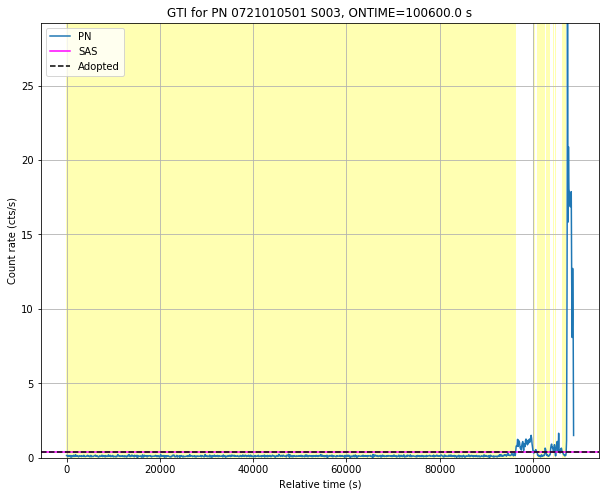

In [95]:
#
# now plotting
f, ax = plt.subplots(figsize=(10,8))
start = hdu[1].data["START"]
end = hdu[1].data["STOP"]
ngti = len(start)
#
reltime = tpn[1].data['TIME'] - time_min
ax.plot(reltime,tpn[1].data['RATE'],label="PN")
rate_lim = 0.4
#
ax.axhline(y=rate_lim,color='magenta',ls='solid',label='SAS')
ax.axhline(y=use_limit,color='k',ls='dashed',label='Adopted'.format(use_limit))
ax.set_ylim((0.0,maxrate))
ax.grid(True)
ax.legend(loc=2)
ax.set_ylabel("Count rate (cts/s)")
#
# now the GTI bands
#
for jj in np.arange(ngti):
    xx = (start[jj]-time_min,end[jj]-time_min)
    yy1 = (0.0,0.0)
    yy2 = (maxrate,maxrate)
    ax.fill_between(xx,yy1,yy2,facecolor='yellow',alpha=0.3)
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("Relative time (s)")
ax.set_title(f"GTI for PN {obsid} {nexpo}, ONTIME={gti_time} s")
#
#png_file = "{}/{}_rates_gti_{}.png".format(ppsDir,obsid,nexpo)
#plt.savefig(png_file,dpi=100)
plt.show();
#logging.info("Saved GTI limits in figure: {}".format(png_file))
#plt.close()

In [84]:
#
# Looking for the Cu line at 8.04 keV
pi0 = 7900 
pi1 = 8100
#
print ("*** Generating images in band [{},{}] eV".format(pi0,pi1))
image_name = f'pn_image_{pi0}_{pi1}_{nexpo}.fits'
#
expr = f'PI in [{pi0}:{pi1}] &&  FLAG==0 && PATTERN in [0:4]'
#    
ev_comm = 'evselect table={} xcolumn=X ycolumn=Y imagebinning=binSize'.format(evlist) +  \
     ' ximagebinsize=80 yimagebinsize=80' + \
     ' expression=\'{}\''.format(expr) +  \
     ' withimageset=true imageset={}'.format(image_name)
status = run_command(ev_comm)
if (status != 0):
    raise Exception

*** Generating images in band [7900,8100] eV
Info: "evselect table=/home/ivaltchanov/IVAN/Cu-line/0721010401/PN_LW/P0721010401PNS003PIEVLI0000.FIT xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PI in [7900:8100] &&  FLAG==0 && PATTERN in [0:4]' withimageset=true imageset=pn_image_7900_8100_S003.fits" returned 0 
 evselect:- Executing (routine): evselect table=/home/ivaltchanov/IVAN/Cu-line/0721010401/PN_LW/P0721010401PNS003PIEVLI0000.FIT filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PI in [7900:8100] &&  FLAG==0 && PATTERN in [0:4]' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=pn_image_7900_8100_S003.fits xcolumn=X ycolumn=Y ximagebinsize=80 yimagebinsize=80 squarepixels=n

Filename: pn_image_7900_8100_S003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (648, 648)   int16   
  1  STDGTI01      1 BinTableHDU    226   6R x 2C   [D, D]   
  2  STDGTI02      1 BinTableHDU    226   6R x 2C   [D, D]   
  3  STDGTI03      1 BinTableHDU    226   6R x 2C   [D, D]   
  4  STDGTI04      1 BinTableHDU    226   4R x 2C   [D, D]   
  5  STDGTI05      1 BinTableHDU    226   4R x 2C   [D, D]   
  6  STDGTI06      1 BinTableHDU    226   4R x 2C   [D, D]   
  7  STDGTI07      1 BinTableHDU    226   5R x 2C   [D, D]   
  8  STDGTI08      1 BinTableHDU    226   5R x 2C   [D, D]   
  9  STDGTI09      1 BinTableHDU    226   5R x 2C   [D, D]   
 10  STDGTI10      1 BinTableHDU    226   5R x 2C   [D, D]   
 11  STDGTI11      1 BinTableHDU    226   5R x 2C   [D, D]   
 12  STDGTI12      1 BinTableHDU    226   5R x 2C   [D, D]   


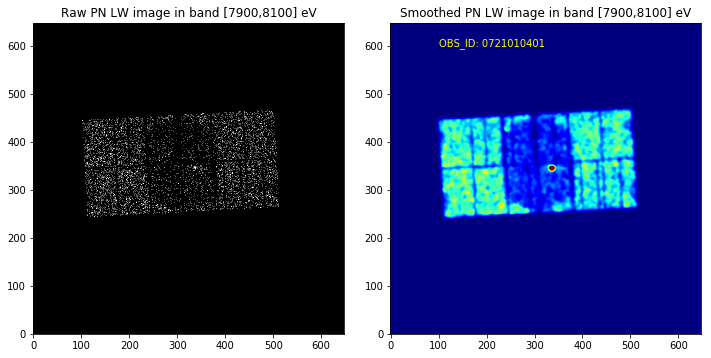

In [85]:
# Display the images
#
hdu = fits.open(image_name)
hdu.info()
pp = 99.9 # 
wcs = WCS(hdu[0].header)
img = hdu[0].data
#
fig = plt.figure(figsize=(20,10))
#ax = fig.add_subplot(1,1,1,projection=wcs)
#lon = ax.coords['ra']
#lon.set_axislabel('RA (J2000.0)')
#lon.set_major_formatter('hh:mm:ss.s')
#lat = ax.coords['dec']
#lat.set_axislabel('Dec (J2000.0)')
#lat.set_major_formatter('dd:mm')    
ax = fig.add_subplot(2,2,1)
ax.set_title(f'Raw PN LW image in band [{pi0},{pi1}] eV')
norm = ImageNormalize(img[~np.isnan(img)], interval=PercentileInterval(pp))
ax.imshow(img,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
#
# now smooth with Gaussian with sigma=6"
#
pixsize = abs(wcs.pixel_scale_matrix[0,0])*3600.0 # in arcsec
width = 12.0/pixsize
sm_img = ndimage.gaussian_filter(img.astype(float), sigma=width, order=0)
ax = fig.add_subplot(2,1,1)
ax.set_title(f'Smoothed PN LW image in band [{pi0},{pi1}] eV')
#pp = 90.0
#norm = ImageNormalize(sm_img[~np.isnan(sm_img)], interval=PercentileInterval(pp))
norm = ImageNormalize(sm_img[~np.isnan(sm_img)], vmin=0.0,vmax=1.0)
ax.imshow(sm_img,norm=norm,cmap=plt.cm.jet,origin='lower',interpolation='nearest')
ax.text(100,600.0,f"OBS_ID: {obsid}",color='yellow')
plt.tight_layout()
plt.show()
plt.savefig(f"{wdir}/{obsid}_CuKa_plot.png",dpi=100)
plt.close();